## <center><span style="font-family: ClearSans, sans-serif; color:#00BBD7">Enhancing Explainability in Credit Scoring</span></center>
## <span style="font-family: ClearSans, sans-serif; color:navyblue">Models</span>
<div class="alert alert-block alert-info">
<b>Description:</b> <span style="font-family: ClearSans, sans-serif;">This notebook contains an implementation of models described in the paper: baseline (WOE LR) and two tree-based models, constrained XGBoost and an extension with Random-Forest base learners.</span></div>

<span style="font-family: ClearSans, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from binning_utils import data_dict, special_codes
from utils import calibration_score

%matplotlib inline

(CVXPY) Sep 29 09:06:33 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 29 09:06:33 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
dataset_D = pd.read_csv("data/Dataset_D.csv", index_col=False)

In [3]:
# features and target
X = dataset_D.copy()
y = X.pop("is_bad")
X.replace(special_codes, np.nan, inplace=True)

# sampling
ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, shuffle=True, random_state=24
)

print(f"Train: {len(ix_train):,.0f}\nTest: {len(ix_test):,.0f}")

Train: 7,000
Test: 3,000


In [4]:
monotonic_constraints_woe = {}
monotonic_constraints_tree = {}

for col, attributes in data_dict.items():
    standardized_name = attributes["standardized_attribute_name"]
    if standardized_name in dataset_D.columns:
        # Check the value of 'causal_knowledge' to determine the monotonic constraint
        if attributes["causal_knowledge"] == -1:
            monotonic_constraints_woe[standardized_name] = {
                "monotonic_trend": "descending"
            }
            monotonic_constraints_tree[standardized_name] = -1
        elif attributes["causal_knowledge"] == 1:
            monotonic_constraints_woe[standardized_name] = {
                "monotonic_trend": "ascending"
            }
            monotonic_constraints_tree[standardized_name] = 1
monotonic_constraints_xgb = [value for key, value in monotonic_constraints_tree.items()]
monotonic_constraints_xgb = ",".join(str(x) for x in monotonic_constraints_xgb)

### <span style="font-family: ClearSans, sans-serif; color:#00BBD7">Baseline: WOE Logistic Regression</span>

In [5]:
from typing import List, Dict, Any
from optbinning import BinningProcess, OptimalBinning
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from utils import create_woe_lr_pipeline

In [6]:
woe_lr_model = create_woe_lr_pipeline(
    X.loc[ix_train],
    y.loc[ix_train],
    variable_names=X.columns.to_list(),
    special_codes=[np.nan],
    binning_fit_params=monotonic_constraints_woe,
    lr_params={
        "fit_intercept": True,
        "penalty": None,
        "random_state": 72,
        "solver": "newton-cg",
    },
)

y_pred_woe = woe_lr_model.predict_proba(X.loc[ix_test])[:, 1]
gini_score_woe_lr = roc_auc_score(y.loc[ix_test], y_pred_woe) * 2 - 1
clb_score_woe_lr = calibration_score(y.loc[ix_test], y_pred_woe)
print(f"Gini score: {gini_score_woe_lr:.2%}")
print(f"Calibration score: {clb_score_woe_lr:.2%}")

Gini score: 76.14%
Calibration score: 87.12%


In [7]:
woe_lr_model_weights = list(zip(X.columns, woe_lr_model[1].coef_.ravel()))
woe_lr_model_weights = pd.DataFrame(woe_lr_model_weights, columns=["feature", "weight"])
woe_lr_model_weights.T

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
feature,external_risk_estimate,months_since_oldest_trade_open,months_since_most_recent_trade_open,average_months_in_file,num_satisfactory_trades,num_trades_60_ever_2_derog_pub_rec,num_trades_90_ever_2_derog_pub_rec,percent_trades_never_delq,months_since_most_recent_delq,num_trades_open_in_last_12m,...,account_never_delinq_percent,balance,num_historical_failed_to_pay,num_total_cc_accounts,num_cc_carrying_balance,age,monthly_income,number_of_dependents,number_real_estate_loans_or_lines,revolving_utilization_of_unsecured_lines
weight,-0.484033,-0.247839,-0.544693,-0.419243,-0.774219,-0.072385,0.146284,-0.295768,-0.322189,-0.032836,...,0.0,-0.492977,0.0,-0.939587,0.999432,-0.537777,-0.782405,-0.433058,-2.208529,-0.941457


In [8]:
# removing flipped signs and 0 coefficients
cols_to_drop = woe_lr_model_weights[woe_lr_model_weights["weight"] >= 0][
    "feature"
].to_list()
cols_to_drop.append("num_trades_60_ever_2_derog_pub_rec")

In [9]:
X_woe = X.drop(columns=cols_to_drop).copy()

woe_lr_model = create_woe_lr_pipeline(
    X_woe.loc[ix_train],
    y.loc[ix_train],
    variable_names=X_woe.columns.to_list(),
    special_codes=special_codes,
    binning_fit_params=monotonic_constraints_woe,
    lr_params={
        "fit_intercept": True,
        "penalty": None,
        "random_state": 72,
        "solver": "newton-cg",
    },
)

y_pred_woe = woe_lr_model.predict_proba(X.loc[ix_test])[:, 1]
gini_score_woe_lr = roc_auc_score(y.loc[ix_test], y_pred_woe) * 2 - 1
clb_score_woe_lr = calibration_score(y.loc[ix_test], y_pred_woe)
print(f"Gini score: {gini_score_woe_lr:.2%}")
print(f"Calibration score: {clb_score_woe_lr:.2%}")

Gini score: 75.91%
Calibration score: 87.10%


### <span style="font-family: ClearSans, sans-serif; color:#00BBD7">Model 1: Constrained XGBoost</span>

In [10]:
import xgboost as xgb
from xgboost import XGBClassifier
import time
from typing import List, Tuple, Dict, Any
import optuna
from optuna.samplers import TPESampler, RandomSampler
from sklearn.model_selection import StratifiedKFold
from utils import create_xgb_pipeline

In [11]:
base_params = {
    "base_score": y.loc[ix_train].mean(),
    "eval_metric": ["auc", "logloss"],
    "missing": np.nan,
    "early_stopping_rounds": 10,
    "monotone_constraints": f"({monotonic_constraints_xgb})",
    "tree_method": "hist",
    "random_state": 24,
}

n_splits = 5


def objective(trial):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    gini_scores = []

    for train_idx, val_idx in skf.split(X.loc[ix_train], y.loc[ix_train]):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.5, step=0.05),
        "max_depth": trial.suggest_int("max_depth", 1, 3),
        "gamma": trial.suggest_float(
            "gamma", 0, 1, step=0.1
        ),  # complexity cost by introducing additional leaf
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1, step=0.01),
        "min_child_weight": trial.suggest_int("min_child_weight", 10, 50),
        "alpha": trial.suggest_float("alpha", 0, 30, step=0.005),
        "lambda": trial.suggest_float("lambda", 0, 30, step=0.005),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
    }

    base_params.update(params)

    xgb_model = XGBClassifier(**base_params)
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred_xgb = xgb_model.predict_proba(X_val)[:, 1]
    gini_score_xgb = roc_auc_score(y_val, y_pred_xgb) * 2 - 1

    gini_scores.append(gini_score_xgb)

    return np.mean(gini_scores)

In [12]:
# study = optuna.create_study(directions=['maximize', 'maximize'])
study_xgb = optuna.create_study(sampler=TPESampler(seed=42), direction="maximize")
study_xgb.optimize(objective, n_trials=100)

[I 2023-09-29 21:06:35,666] A new study created in memory with name: no-name-f3389741-820b-443b-b8a4-80f6e9dde451
[I 2023-09-29 21:06:35,761] Trial 0 finished with value: 0.8767121492142136 and parameters: {'n_estimators': 40, 'learning_rate': 0.5, 'max_depth': 3, 'gamma': 0.6000000000000001, 'subsample': 0.55, 'colsample_bytree': 0.5700000000000001, 'min_child_weight': 12, 'alpha': 25.985, 'lambda': 18.035, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8767121492142136.
[I 2023-09-29 21:06:35,863] Trial 1 finished with value: 0.8764849549325189 and parameters: {'n_estimators': 98, 'learning_rate': 0.45000000000000007, 'max_depth': 1, 'gamma': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.65, 'min_child_weight': 31, 'alpha': 12.96, 'lambda': 8.735, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8767121492142136.
[I 2023-09-29 21:06:35,923] Trial 2 finished with value: 0.8799933589363811 and parameters: {'n_estimators': 33, 'learning_rate': 0.25, 'max_depth': 2, 

In [13]:
best_hyperparameters_xgb = study_xgb.best_trial.params
print(
    f"Best value: {study_xgb.best_value:.2%}, Best params: {best_hyperparameters_xgb}"
)

eval_set = [(X.loc[ix_train], y.loc[ix_train]), (X.loc[ix_test], y.loc[ix_test])]

xgb_model = create_xgb_pipeline(
    X.loc[ix_train], y.loc[ix_train], best_hyperparameters_xgb, eval_set
)

y_pred_xgb = xgb_model.predict_proba(X.loc[ix_test])[:, 1]
gini_score_xgb = roc_auc_score(y.loc[ix_test], y_pred_xgb) * 2 - 1
clb_score_xgb = calibration_score(y.loc[ix_test], y_pred_xgb)
print(f"Gini score: {gini_score_xgb:.2%}")
print(f"Calibration score: {clb_score_xgb:.2%}")
print(f"Max prediction: {y_pred_xgb.max():.2%}")

Best value: 88.90%, Best params: {'n_estimators': 90, 'learning_rate': 0.5, 'max_depth': 1, 'gamma': 0.4, 'subsample': 0.95, 'colsample_bytree': 0.5700000000000001, 'min_child_weight': 21, 'alpha': 2.9250000000000003, 'lambda': 14.15, 'grow_policy': 'depthwise'}
Gini score: 91.01%
Calibration score: 90.22%
Max prediction: 97.89%


### <span style="font-family: ClearSans, sans-serif; color:#00BBD7">Model 2: Constrained XGBoost with Random Forests</span>

In [14]:
base_params = {
    "base_score": y.loc[ix_train].mean(),
    "eval_metric": ["auc", "logloss"],
    "missing": np.nan,
    "early_stopping_rounds": 10,
    "monotone_constraints": f"({monotonic_constraints_xgb})",
    "tree_method": "hist",
    "random_state": 24,
}

n_splits = 5


def objective(trial):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    gini_scores = []

    for train_idx, val_idx in skf.split(X.loc[ix_train], y.loc[ix_train]):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.5, step=0.05),
        "max_depth": trial.suggest_int("max_depth", 1, 3),
        "num_parallel_tree": trial.suggest_int("num_parallel_tree", 2, 3),
        "gamma": trial.suggest_float(
            "gamma", 0, 1, step=0.1
        ),  # complexity cost by introducing additional leaf
        "subsample": trial.suggest_float("subsample", 0.5, 1, step=0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1, step=0.01),
        "min_child_weight": trial.suggest_int("min_child_weight", 10, 50),
        "alpha": trial.suggest_float("alpha", 0, 30, step=0.005),
        "lambda": trial.suggest_float("lambda", 0, 30, step=0.005),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
    }

    base_params.update(params)

    xgb_rf_model = XGBClassifier(**base_params)
    xgb_rf_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred_xgb_rf = xgb_rf_model.predict_proba(X_val)[:, 1]
    gini_score_xgb_rf = roc_auc_score(y_val, y_pred_xgb_rf) * 2 - 1

    gini_scores.append(gini_score_xgb_rf)

    return np.mean(gini_scores)

In [15]:
study_xgb_rf = optuna.create_study(sampler=TPESampler(seed=42), direction="maximize")
study_xgb_rf.optimize(objective, n_trials=100)

[I 2023-09-29 21:06:48,133] A new study created in memory with name: no-name-f13faf47-2674-4e46-915e-828954f61098
[I 2023-09-29 21:06:48,200] Trial 0 finished with value: 0.8676768073960477 and parameters: {'n_estimators': 12, 'learning_rate': 0.5, 'max_depth': 3, 'num_parallel_tree': 3, 'gamma': 0.1, 'subsample': 0.55, 'colsample_bytree': 0.52, 'min_child_weight': 45, 'alpha': 18.035, 'lambda': 21.245, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.8676768073960477.
[I 2023-09-29 21:06:48,274] Trial 1 finished with value: 0.8680132296977878 and parameters: {'n_estimators': 25, 'learning_rate': 0.15000000000000002, 'max_depth': 1, 'num_parallel_tree': 2, 'gamma': 0.30000000000000004, 'subsample': 0.75, 'colsample_bytree': 0.72, 'min_child_weight': 21, 'alpha': 18.355, 'lambda': 4.1850000000000005, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.8680132296977878.
[I 2023-09-29 21:06:48,333] Trial 2 finished with value: 0.8725309006068709 and parameters: {'n_estima

In [16]:
best_hyperparameters_rf = study_xgb_rf.best_trial.params
print(
    f"Best value: {study_xgb_rf.best_value:.2%}, Best params: {best_hyperparameters_rf}"
)

eval_set = [(X.loc[ix_train], y.loc[ix_train]), (X.loc[ix_test], y.loc[ix_test])]

xgb_rf_model = create_xgb_pipeline(
    X.loc[ix_train], y.loc[ix_train], best_hyperparameters_rf, eval_set
)

y_pred_xgb_rf = xgb_rf_model.predict_proba(X.loc[ix_test])[:, 1]
gini_score_xgb_rf = roc_auc_score(y.loc[ix_test], y_pred_xgb_rf) * 2 - 1
clb_score_xgb_rf = calibration_score(y.loc[ix_test], y_pred_xgb_rf)
print(f"Gini score: {gini_score_xgb_rf:.2%}")
print(f"Calibration score: {clb_score_xgb_rf:.2%}")
print(f"Max prediction: {y_pred_xgb_rf.max():.2%}")

Best value: 88.30%, Best params: {'n_estimators': 29, 'learning_rate': 0.4, 'max_depth': 2, 'num_parallel_tree': 3, 'gamma': 0.5, 'subsample': 0.65, 'colsample_bytree': 0.9199999999999999, 'min_child_weight': 20, 'alpha': 0.39, 'lambda': 23.085, 'grow_policy': 'lossguide'}
Gini score: 90.60%
Calibration score: 89.95%
Max prediction: 96.22%


In [17]:
print(f"XGB score: {gini_score_xgb:.2%}, XGB RF score: {gini_score_xgb_rf:.2%}")
best_hyperparameters_xgb, best_hyperparameters_rf

XGB score: 91.01%, XGB RF score: 90.60%


({'n_estimators': 90,
  'learning_rate': 0.5,
  'max_depth': 1,
  'gamma': 0.4,
  'subsample': 0.95,
  'colsample_bytree': 0.5700000000000001,
  'min_child_weight': 21,
  'alpha': 2.9250000000000003,
  'lambda': 14.15,
  'grow_policy': 'depthwise'},
 {'n_estimators': 29,
  'learning_rate': 0.4,
  'max_depth': 2,
  'num_parallel_tree': 3,
  'gamma': 0.5,
  'subsample': 0.65,
  'colsample_bytree': 0.9199999999999999,
  'min_child_weight': 20,
  'alpha': 0.39,
  'lambda': 23.085,
  'grow_policy': 'lossguide'})

### <span style="font-family: ClearSans, sans-serif; color:#00BBD7">Performance</span>

In [135]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay
from utils import plot_cap

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


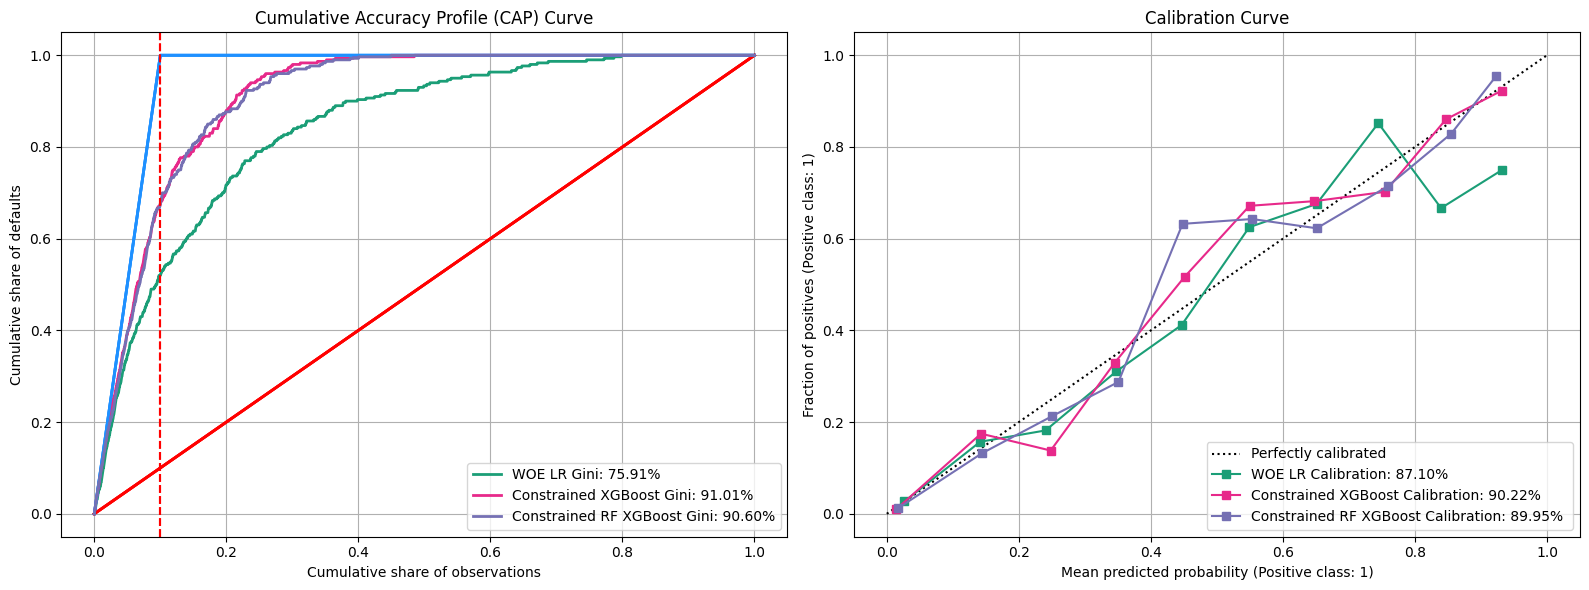

In [449]:
# Create a figure with one row and two columns
fig = plt.figure(figsize=(16, 6))

# Create the GridSpec layout
gs = GridSpec(1, 2, width_ratios=[1, 1])

# Plot the first subplot (Cumulative Accuracy Profile - CAP Curve)
colors = plt.cm.get_cmap("Dark2")

ax1 = plt.subplot(gs[0])
plot_cap(
    y.loc[ix_test],
    woe_lr_model.predict_proba(X.loc[ix_test])[:, 1],
    legend_title=f"WOE LR Gini: {gini_score_woe_lr:.2%}",
    line_color=colors(0),
    ax=ax1,
)
plot_cap(
    y.loc[ix_test],
    xgb_model.predict_proba(X.loc[ix_test])[:, 1],
    legend_title=f"Constrained XGBoost Gini: {gini_score_xgb:.2%}",
    line_color=colors(3),
    ax=ax1,
)
plot_cap(
    y.loc[ix_test],
    xgb_rf_model.predict_proba(X.loc[ix_test])[:, 1],
    legend_title=f"Constrained RF XGBoost Gini: {gini_score_xgb_rf:.2%}",
    line_color=colors(2),
    ax=ax1,
)

ax1.axvline(x=0.1, linestyle="--", color="r")

ax1.grid()
ax1.tick_params(labelsize=10)
ax1.set_xlabel("Cumulative share of observations", fontsize=10)
ax1.set_ylabel("Cumulative share of defaults", fontsize=10)
ax1.axvline(x=0.1, linestyle="--", color="r")
ax1.set_title("Cumulative Accuracy Profile (CAP) Curve", fontsize=12)
ax1.legend(fontsize=10)

# Plot the second subplot (Calibration Curve)
ax2 = plt.subplot(gs[1])

clf_list = [
    (woe_lr_model, "WOE LR"),
    (xgb_model, "Constrained XGBoost"),
    (xgb_rf_model, "Constrained RF XGBoost"),
]

colors = plt.colormaps.get_cmap("Dark2")

calibration_displays = {}

colors_clb = [0, 3, 2]
for i, (clf, name) in enumerate(clf_list):
    preds = clf.predict_proba(X.loc[ix_test])[:, 1]
    clb_score = calibration_score(y.loc[ix_test], preds)
    calibration_display = CalibrationDisplay.from_estimator(
        clf,
        X.loc[ix_test],
        y.loc[ix_test],
        ax=ax2,  # Specify the second subplot
        n_bins=10,
        name=f"{name} Calibration: {clb_score:.2%} ",
        color=colors(colors_clb[i]),
    )
    calibration_displays[name] = calibration_display

ax2.set_title("Calibration Curve")
ax2.grid()

# Adjust spacing between subplots
plt.tight_layout()
fig.savefig("images/performance_1200.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)
plt.show()

### <span style="font-family: ClearSans, sans-serif; color:#00BBD7">Interpretability</span>

#### <span style="font-family: ClearSans, sans-serif; color:#00BBD7">SHAP</span>

In [21]:
import shap
import warnings

shap.initjs()
warnings.filterwarnings("ignore")

In [75]:
# WOE LR
feature_names = woe_lr_model[0].variable_names
X_shap = X[woe_lr_model[0].variable_names].loc[ix_test].copy()
observations = pd.DataFrame(
    woe_lr_model[0].transform(X_shap).values, columns=feature_names
)
masker = shap.maskers.Independent(observations.values, 100)
explainer = shap.Explainer(
    woe_lr_model[1].predict_proba, masker.data, feature_names=list(X_woe.columns)
)

shap_values_woe = explainer(observations)
# shap.plots.bar(shap_values_woe[:, :, 1])

# XGB
explainer = shap.explainers.Permutation(xgb_model.predict_proba, X.loc[ix_test])
shap_values_xgb = explainer(X.loc[ix_test])
# shap.plots.bar(shap_values_xgb[:, :, 1])

# XGB RF
explainer = shap.explainers.Permutation(xgb_rf_model.predict_proba, X.loc[ix_test])
shap_values_xgb_rf = explainer(X.loc[ix_test])
# shap.plots.bar(shap_values_xgb_rf[:, :, 1])

Permutation explainer: 3001it [00:14, 62.89it/s]                           
Permutation explainer: 3001it [01:12, 35.35it/s]                          
Permutation explainer: 3001it [01:20, 32.66it/s]                          


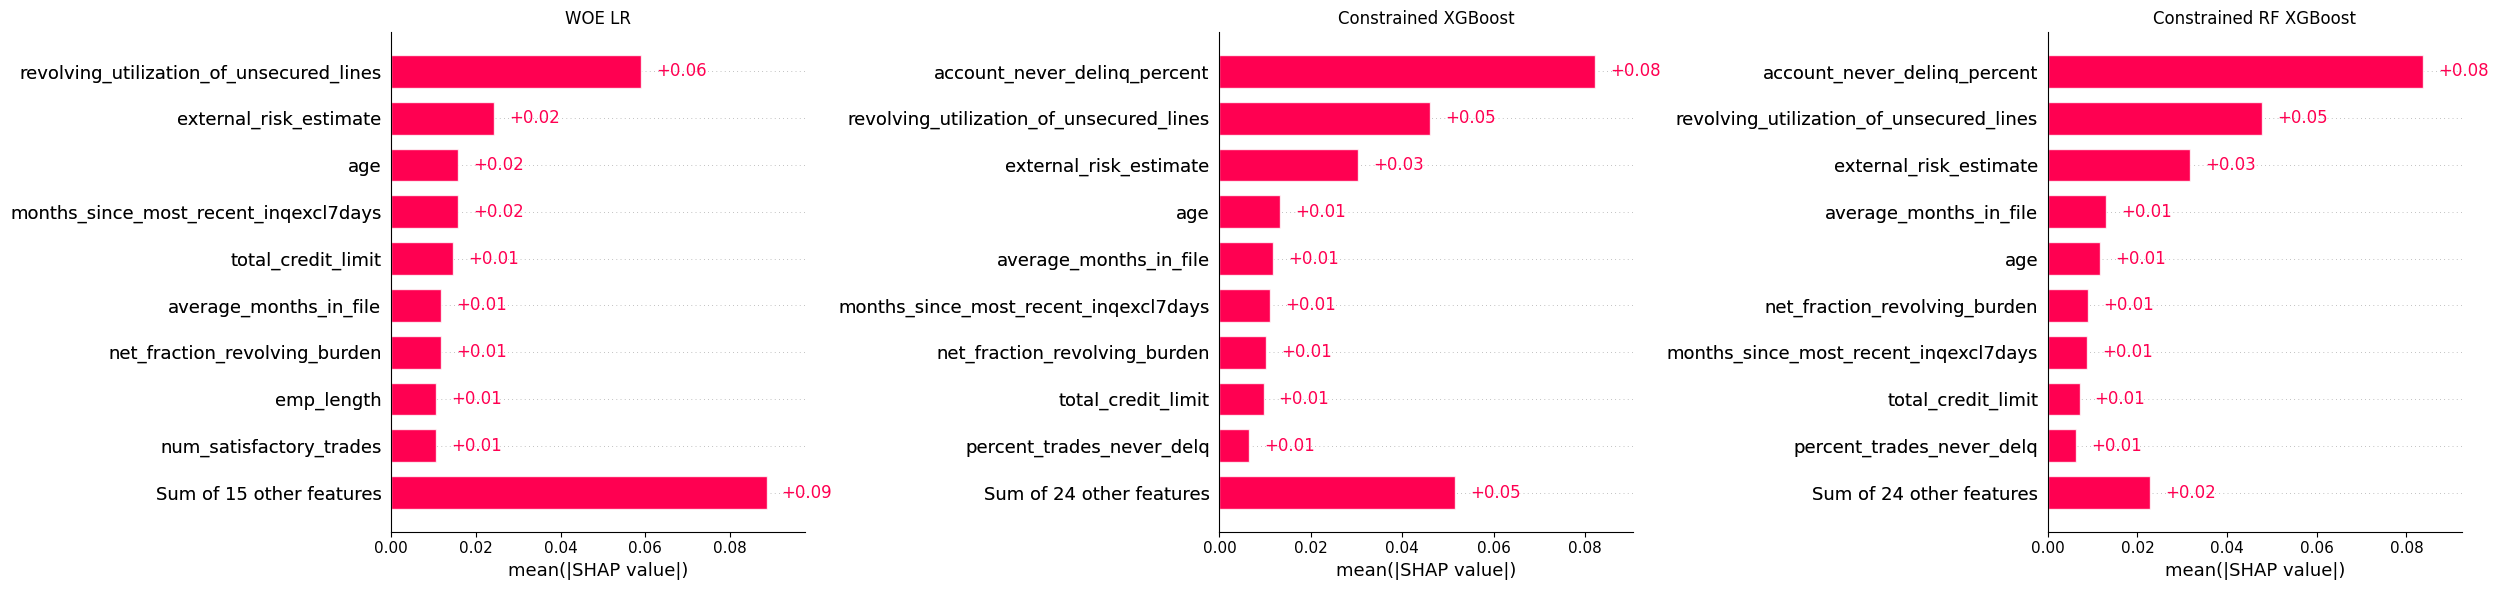

In [452]:
fig = plt.figure()
ax0 = fig.add_subplot(131)
shap.plots.bar(shap_values_woe[:, :, 1], show=False, max_display=10)
ax1 = fig.add_subplot(132)
shap.plots.bar(shap_values_xgb[:, :, 1], show=False, max_display=10)
ax2 = fig.add_subplot(133)
shap.plots.bar(shap_values_xgb_rf[:, :, 1], show=False, max_display=10)
ax0.set_title("WOE LR", fontsize=12)
ax1.set_title("Constrained XGBoost", fontsize=12)
ax2.set_title("Constrained RF XGBoost", fontsize=12)
plt.gcf().set_size_inches(25, 6)
plt.tight_layout()
fig.savefig("images/shap_importances_1200.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)
plt.show()

#### <span style="font-family: ClearSans, sans-serif; color:#00BBD7">Scorecards</span>

In [ ]:
from optbinning import Scorecard
from utils import XGBoostTreeParser, get_credit_scores

In [229]:
scorecard = Scorecard(
    binning_process=woe_lr_model[0],
    estimator=woe_lr_model[1],
    scaling_method="pdo_odds",
    scaling_method_params={"pdo": 50, "odds": 19, "scorecard_points": 500},
)

scorecard.fit(X_woe.loc[ix_train], y.loc[ix_train], show_digits=4)

sc = scorecard.table(style="summary")
# display(sc.groupby("Variable").agg({'Points' : [np.min, np.max]}).sum())

y_pred_woe = scorecard.predict_proba(X_woe.loc[ix_test])[:, 1]
score_woe = scorecard.score(X_woe.loc[ix_test])

bstr_xgb = xgb_model.get_booster()
xgb_tree_parser = XGBoostTreeParser(bstr_xgb)
scorecard_xgb = xgb_tree_parser.generate_scorecard(
    bstr_xgb, PDO=40, standardSc_pts=500, standardSc_odds=19
)
score_xgb = get_credit_scores(X.loc[ix_test], X.columns.to_list(), scorecard_xgb)

bstr_rf = xgb_rf_model.get_booster()
xgb_rf_tree_parser = XGBoostTreeParser(bstr_rf)
scorecard_xgb_rf = xgb_rf_tree_parser.generate_scorecard(
    bstr_rf, PDO=40, standardSc_pts=500, standardSc_odds=19
)
score_xgb_rf = get_credit_scores(X.loc[ix_test], X.columns.to_list(), scorecard_xgb_rf)

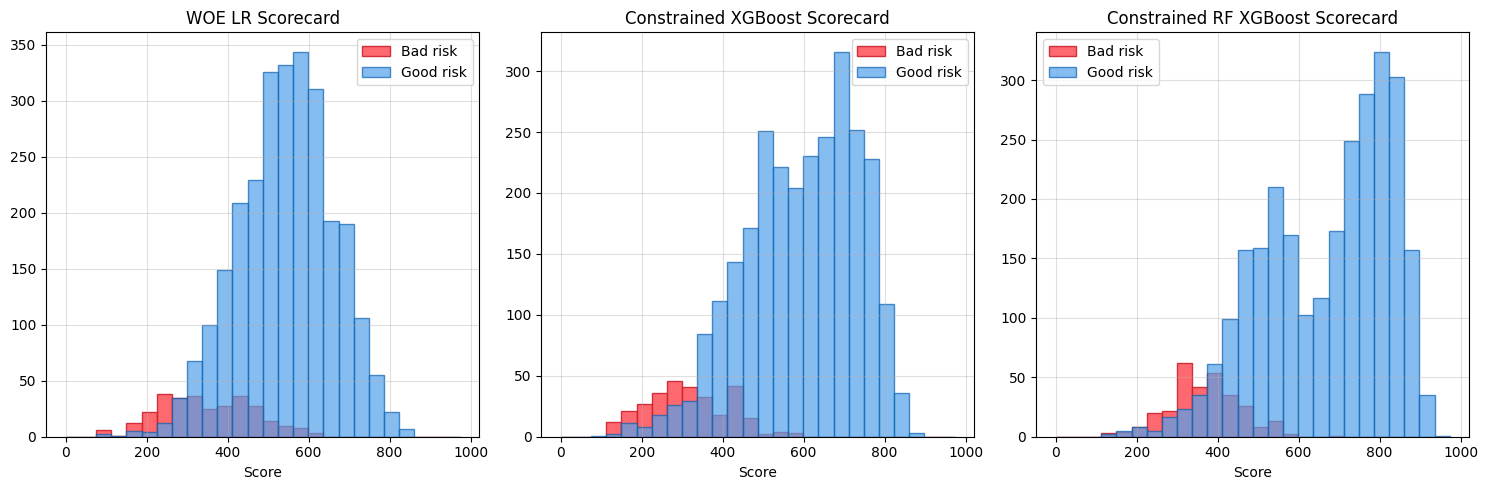

In [453]:
# Create a dictionary to map model names to labels
model_labels = {
    "score_woe": "WOE LR",
    "score_xgb": "Constrained XGBoost",
    "score_xgb_rf": "Constrained RF XGBoost",
}

# Create a new DataFrame with scores from all three models
score_df = pd.DataFrame(
    {
        "score_woe": np.round(scorecard.score(X_woe.loc[ix_test])),
        "score_xgb": np.round(score_xgb["Score"]),
        "score_xgb_rf": np.round(score_xgb_rf["Score"]),
        "is_bad": y.loc[ix_test],
    }
)

# Determine the range of scores
score_min = score_df.min().min()
score_max = score_df.max().max()

# Define the number of bins and bin width
num_bins = 25
bin_width = (score_max - score_min) / num_bins

# Create subplots with one row and three columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for all three models
for i, model_name in enumerate(["score_woe", "score_xgb", "score_xgb_rf"]):
    axes[i].hist(
        score_df[score_df["is_bad"] == 1][model_name].sample(frac=1, replace=True),
        label="Bad risk",
        color="#fe595f",
        edgecolor="#cc212e",
        alpha=0.9,
        bins=np.arange(score_min, score_max + bin_width, bin_width),
    )
    axes[i].hist(
        score_df[score_df["is_bad"] == 0][model_name].sample(frac=1, replace=False),
        label="Good risk",
        color="#52a1ec",
        edgecolor="#0b62af",
        alpha=0.7,
        bins=np.arange(score_min, score_max + bin_width, bin_width),
    )
    axes[i].grid(alpha=0.4)
    axes[i].set_xlabel("Score")
    axes[i].set_title(f"{model_labels[model_name]} Scorecard")
    axes[i].legend()

plt.tight_layout()
fig.savefig("images/scorecards.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)

plt.show()

#### <span style="font-family: ClearSans, sans-serif; color:#00BBD7">Scorecard importances</span>

In [423]:
from utils import woe_scorer

In [429]:
# scorecard.py adaptation to get individual scores
score_woe = X_woe.loc[ix_test].copy()
for feature in X_woe.columns:
    feature_scores = abs(
        woe_scorer(X=X_woe.loc[ix_test], scorecard=scorecard, variable_name=feature)
    )
    score_woe[feature] = feature_scores
score_woe["Score"] = score_woe.sum(axis=1)

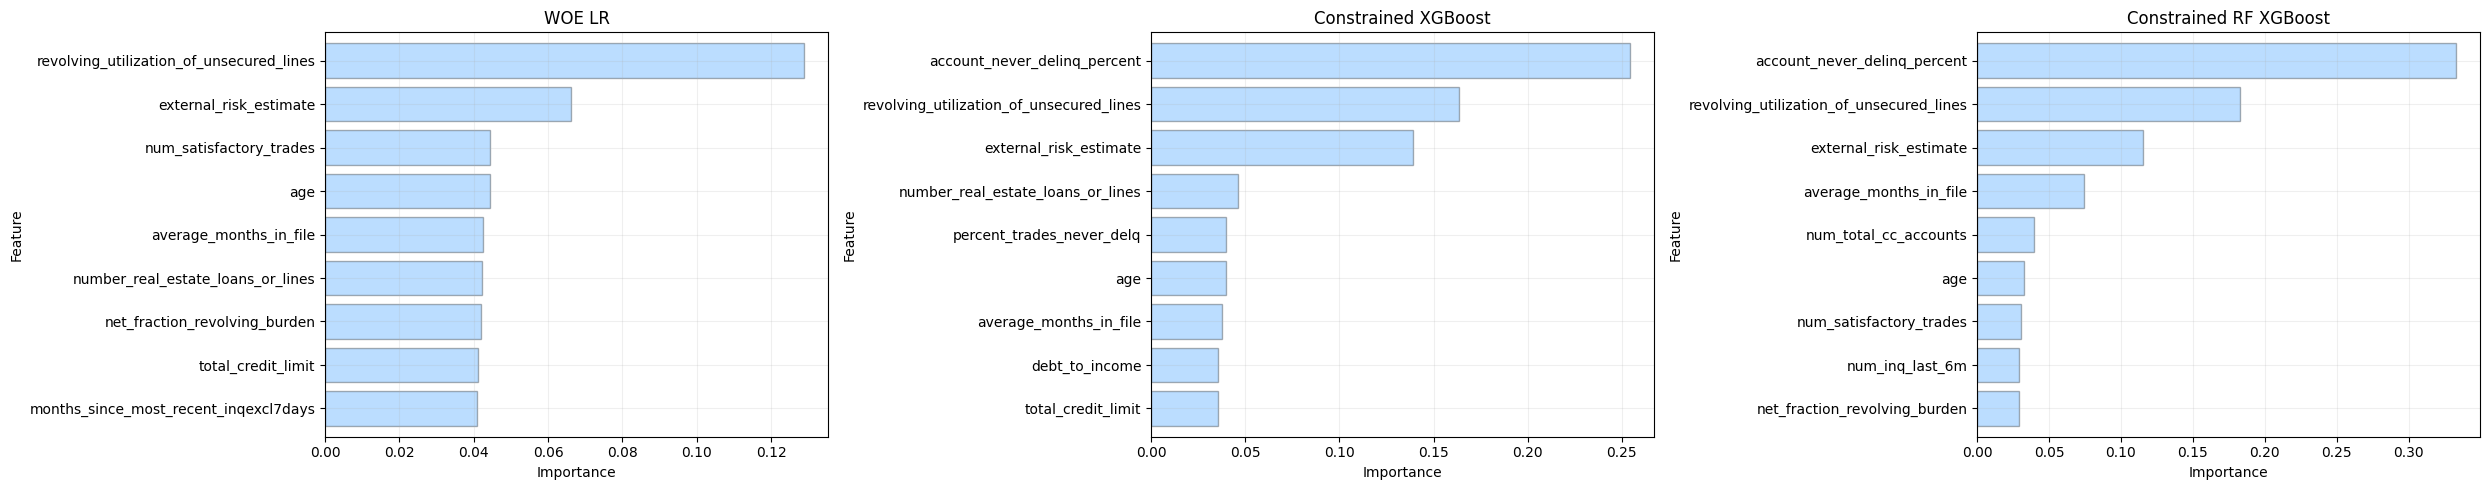

In [454]:
dataframes = [
    ("score_woe", score_woe),
    ("score_xgb", score_xgb),
    ("score_xgb_rf", score_xgb_rf),
]

fig, axes = plt.subplots(1, 3, figsize=(25, 5))

for i, (df_name, df) in enumerate(dataframes):
    feats = df.columns.to_list()
    feats.remove("Score")

    importances = {"Feature": [], "Importance": []}

    for feat in feats:
        importance = (df[feat] / df["Score"]).mean()
        importances["Feature"].append(feat)
        importances["Importance"].append(importance)

    bstr_importances = pd.DataFrame(importances).sort_values(
        by="Importance", ascending=True
    )
    # Select top features
    bstr_importances_top = bstr_importances.sort_values(
        by="Importance", ascending=False
    )[0:9]
    top_imp = bstr_importances_top.iloc[:, 0].to_list()

    bstr_importances[bstr_importances["Feature"].isin(top_imp)].plot(
        kind="barh",
        width=0.8,
        color="dodgerblue",
        title=f"{model_labels[df_name]}",
        alpha=0.3,
        x="Feature",
        legend=False,
        xlabel="Importance",
        edgecolor="black",
        ax=axes[i],
    )
    axes[i].grid(alpha=0.2)

plt.tight_layout()
fig.savefig("images/scorecard_importances.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)

plt.show()